<h1 align='center'>Dropout as Regularization and Bayesian Approximation</h1>

 <center>Weidong Xu, Zeyu Zhao, Tianning Zhao</center>

## 1. Introduction
Deep neural network is a very powerful tool in machine learning. Multiple non-linear hidden layers enable the model to learn complicated relationships between input and output. However, when the training set is small, there are different parameter settings that would fits training set perfectly, but the one complex parameter setting tends to perform poorly on the test dataset, ie we got the problem of overfitting. One way to solve this problem is by averaging predictions of different neural networks , but this becomes computationally expensive when applied to large datasets. The alternative that makes it possible to train a huge number of different networks in a reasonable time is dropout, which randomly omits some hidden units i.e. feature detectors to prevent co-adaption. The idea of dropout model can be shown as below.
![Dropout_model.png](Dropout_model.png)
ref: Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. The Journal of Machine Learning Research, 15(1), 1929-1958.

## 2. Model Description
With dropout, the feed-forward operation of neural networks can be described as :

$$r_j^{(l)} \sim Bernoulli(p),$$
$$\tilde y^{(l)} = r^{(l)} \times y^{(l)},$$
$$z_i^{(l+1)} = w_i^{(l+1)}\tilde y^{(l)} + b_i^{(l+1)},$$
$$y_i^{(l+1)} = f(z_i^{(l+1)})$$

where $l$ is the index the hidden layers of the network, $z^{(l)}$ denote
the vector of inputs into layer $l$, $y^{(l)}$ denote the vector of outputs from layer $l$ ($y^{(0)} = x$ is the input). $w^{(l)}$ and $b^{(l)}$ are the weights and biases at layer $l$. f is any activation function.

With this, the standard stochastic gradient descent procedure was used for training the dropout neural networks on mini-batches of training cases. **penalty modification???** 

For testing, we use the “mean network” that contains all of the hidden units with their outgoing weights halved instead of averaging over a large number of dropout networks. **Description for mean network???**

## 3. Dropout as regularization

### Import necessary  libraries

We use GPUs for deep learning. If you want to try our code in CPU, remove all `.cuda()` in the notebook.

In [1]:
%env CUDA_VISIBLE_DEVICES=2
import numpy as np
import pandas as pd
from copy import deepcopy
import time

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

env: CUDA_VISIBLE_DEVICES=2


### Load MNIST Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

### Dropout Implementation

We should multiply the dropout output by $\frac{1}{1-p}$ where $p$ is the dropout rate to compensate for the dropped neurons. We implemented a dropout layer below, it should have same functionality as `nn.Dropout` in Pytorch.

In [3]:
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0-p)
        else:
            self.multiplier_ = 0.0
    def forward(self, input):
        if not self.training:
            return input
        selected_ = torch.Tensor(input.shape).uniform_(0,1)>self.p
        #selected_num = torch.sum(selected_)
        #if selected_num > 0:
        #    multiplier_ = torch.numel(selected_)/selected_num
        #else:
        #    multiplier_ = 0
        if input.is_cuda:
            selected_ = Variable(selected_.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ = Variable(selected_.type(torch.FloatTensor), requires_grad=False)
        return torch.mul(selected_,input) * self.multiplier_

### Build the Network

We use the code below to build the network as described in the paper.

In [4]:
def getData(testloader):
    return iter(testloader).next()

def accuracy_score(y_true, y_pred, verbose=False):
    if not verbose:
        return np.mean(y_true == y_pred)
    else:
        return np.array([np.mean(y_pred_test[y_test == i] == i) for i in range(10)])
    
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("dropout0",MyDropout(p=droprates[0]))
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("tanh", nn.Tanh())
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden"+str(i+1), MyDropout(p=droprates[1]))
            self.model.add_module("hidden"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))
        #self.model.add_module("logsoftmax", nn.LogSoftmax(dim=1))
        
        
    def forward(self, x):
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x
    
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=100, max_epoch=10, \
                 lr=0.1, momentum=0):
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates)
        self.model.cuda()
        #self.criterion = nn.NLLLoss()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = getData(testloader)
        X_test = X_test.cuda()
        print(self)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose or epoch + 1 == self.max_epoch:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        print('Finished Training.')
        return self
    
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)

The paper tried three networks. One with no dropout, one with dropout in hidden layers and one with dropout in both hidden layers and input. The training takes really long time. We recommend using GPU to reproduce our results.

You can set `verbose=True` to see loss and accuracy of each epoch.

In [5]:
hidden_layers = [800, 800]
mlp1 = [MLPClassifier(hidden_layers, droprates=[0, 0], max_epoch=1500), 
        MLPClassifier(hidden_layers, droprates=[0, 0.5], max_epoch=1500),
        MLPClassifier(hidden_layers, droprates=[0.2, 0.5], max_epoch=1500)]

In [6]:
%%time

print(mlp1[0].model)
mlp1[0].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0, 0]
Test error: 169; test accuracy: 0.9831
Finished Training.
CPU times: user 2h 7min 47s, sys: 3min 25s, total: 2h 11min 12s
Wall time: 2h 11min 8s


In [7]:
%%time

print(mlp1[1].model)
mlp1[1].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0, 0.5]
Test error: 149; test accuracy: 0.9851
Finished Training.
CPU times: user 2h 8min 3s, sys: 3min 24s, total: 2h 11min 27s
Wall time: 2h 11min 24s


In [8]:
%%time

print(mlp1[2].model)
mlp1[2].fit(trainset, testset,verbose=False);

MLP(
  (model): Sequential(
    (dropout0): MyDropout(
    )
    (input): Linear(in_features=784, out_features=800)
    (tanh): Tanh()
    (dropout_hidden1): MyDropout(
    )
    (hidden1): Linear(in_features=800, out_features=800)
    (tanh_hidden1): Tanh()
    (final): Linear(in_features=800, out_features=10)
  )
)
Hidden layers: [800, 800]; dropout rates: [0.2, 0.5]
Test error: 112; test accuracy: 0.9887
Finished Training.
CPU times: user 1h 59min 20s, sys: 3min 13s, total: 2h 2min 34s
Wall time: 2h 2min 29s


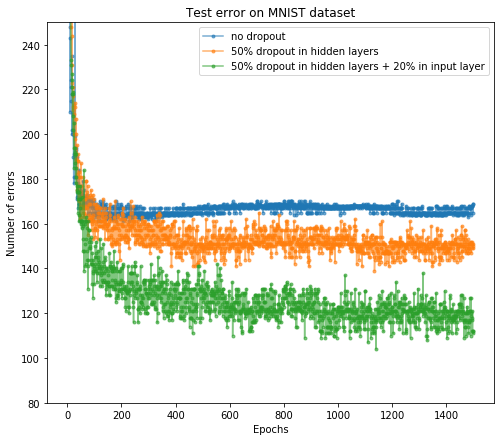

In [9]:
results = [(mlp.loss_, mlp.test_accuracy, mlp.test_error) for mlp in mlp1]
labels = ['no dropout', '50% dropout in hidden layers', '50% dropout in hidden layers + 20% in input layer']

plt.figure(figsize=(8, 7))
for i, r in enumerate(results):
    plt.plot(range(1, len(r[2])+1), r[2], '.-', label=labels[i], alpha=0.6);
plt.ylim([80, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors');
plt.title('Test error on MNIST dataset');

The result above is similar to what is described in the paper. As we can see, dropout works.

## 4. Bayesian Approximation
It is shown that deep NNs with dropout applied before every weight layer are mathematically equivalent to approximate variational inference in the deep Gaussian process marginalised over its covariance function parameters (Yarin Gal et al). 

The related Gaussian process could be described as below:

$$F \vert X, W_1, b \sim N(0, K(X,X))$$
$$Y \vert F \sim N(F, \tau^{-1}I_N)$$
Introduing $W_1$, which is a matrix parameterizing the covariance function K:
$$ p(Y\vert X) = \int p(Y\vert F)p(F\vert W_1, b, X)p(W_1)p(b)$$
Introduing $W_2$, another matrix that get the integration rid of F:
$$ p(Y\vert X) = \int p(Y\vert X, W_1, W_2, b)p(W_1)p(W_2)p(b)$$
To perform variational inference in our approximate model we need to define a variational distribution $q(W_1, W_2, b) := q(W_1)q(W_2)q(b)$, where $q(W_1)$ and $q(W_2)$ are defined as a Gaussian mixture model with two components, factorized over dimensinality of $W_1$ and $W_2$. For example: 

$$q(W_1) = \prod_{q=1}^{Q}q(w_q) $$
$$ q(w_q) = p_1N(m_q, \sigma^2I_K) + (1-p_1)N(0,\sigma^2I_K)$$

with some probability p1 ∈ [0, 1], scalar σ > 0 and $m_q ∈ R^K $

In dropout model, the input was weighted by some weight matrix and then pass into some non-linear function, which is the same as what we did with the parameterizing matrix and covariance function. The output of the non-linear function would be the input of the next hidden layer. When we implement dropout, we actually created a binary vector to decide which hidden unit would be passed to the next layer, which is similar to what we did for the variational inference. With this setup, we update the parameters by minimizing some loss function we choose, just as minimizing KL divergence in Gaussian process approximation.


### 4.1. Dropout as Bayesian Approximation in Regression Task

We use keras for this task. Keras has `Dropout` implementation same to what we implemented above.

In [1]:
import sys

import warnings
warnings.filterwarnings("ignore")

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from keras.utils import to_categorical
from keras.regularizers import l2

from keras.models import load_model

import pymc3 as pm

import numpy as np
import pandas as pd
import time
import h5py

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

import pickle

class IO:
    def __init__(self, file_name):
        self.file_name = file_name
        
    def to_pickle(self, obj):
        with open(self.file_name, 'wb') as output:
            pickle.dump(obj, output, protocol=pickle.HIGHEST_PROTOCOL)
    
    def read_pickle(self):
        with open(self.file_name, 'rb') as input_:
            obj = pickle.load(input_)
        return obj

Using TensorFlow backend.


In [2]:
f = h5py.File('data/train.h5', 'r')
data_train = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()
X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)
print(data_train.shape)

f = h5py.File('data/test.h5', 'r')
data_test = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()

X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

(272, 2)


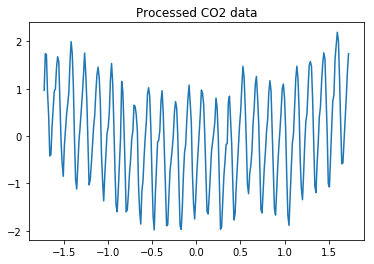

In [3]:
plt.plot(data_train[:, 0], data_train[:, 1]);
plt.title('Processed CO2 data');

In [4]:
class FFNN2:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024], droprate=0.1, activation='relu'):
        reg = 1e-6
        model = Sequential()
        model.add(Dense(hidden_layers[0], activation=activation, input_shape=(1, ), kernel_initializer='lecun_uniform', \
                        W_regularizer=l2(reg)))
        for d in hidden_layers[1:]:
            model.add(Dropout(droprate))
            model.add(Dense(d, activation=activation, kernel_initializer='lecun_uniform', \
                            W_regularizer=l2(reg)))
        model.add(Dropout(droprate))
        model.add(Dense(1, W_regularizer=l2(reg)))
        self.model = model
        
    def fit(self, X_train, y_train, lr=0.0001, epochs=1000000, batch_size=100, verbose=0):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.model.compile(loss='mean_squared_error', optimizer=Adam(lr=lr))
        self.result = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return self
    
def predict(model, X, T=10000):
    # Reference: https://github.com/yaringal/DropoutUncertaintyExps/blob/master/bostonHousing/net/net/net.py
    standard_pred = model.predict(X)
    predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    Yt_hat = np.array([predict_stochastic([X, 1]) for _ in range(T)]).squeeze()
    return standard_pred, Yt_hat

In [ ]:
%%time

ffnn2_relu = FFNN2(activation='relu').fit(X_train, y_train, verbose=1)
ffnn2_relu.model.save('results/co2_regression_MC_relu.h5')

In [ ]:
%%time

model = load_model('results/co2_regression_MC_relu.h5')
y_pred, y_hat = predict(model, X_test)
y_mc = y_hat.mean(axis=0)
y_mc_std = y_hat.std(axis=0)
IO('results/co2_regression_MC_relu_results.pkl').to_pickle((y_pred, y_mc, y_mc_std))

In [ ]:
%%time

ffnn2_tanh = FFNN2(activation='tanh').fit(X_train, y_train, verbose=1)
ffnn2_tanh.model.save('results/co2_regression_MC_tanh.h5')

In [ ]:
%%time

model = load_model('results/co2_regression_MC_tanh.h5')
y_pred, y_hat = predict(model, X_test)
y_mc = y_hat.mean(axis=0)
y_mc_std = y_hat.std(axis=0)
IO('results/co2_regression_MC_tanh_results.pkl').to_pickle((y_pred, y_mc, y_mc_std))

In [ ]:
with pm.Model() as m:
    l = pm.HalfCauchy('l', 0.05)
    eta = pm.HalfCauchy('eta', 1)
    sigma = pm.HalfCauchy('sigma', 0.1)
        
    gp = pm.gp.Marginal(cov_func=(eta ** 2) * pm.gp.cov.ExpQuad(1, l))
    obs = gp.marginal_likelihood('obs', X=X_train, y=y_train.squeeze(), noise=sigma, is_observed=True)

In [ ]:
%%time

with m:
    step = pm.NUTS(target_accept=0.95)
    trace1 = pm.sample(5000, tune=2000, step=step, njobs=2)

IO('results/co2_regression_gp.pkl').to_pickle((m, trace1))

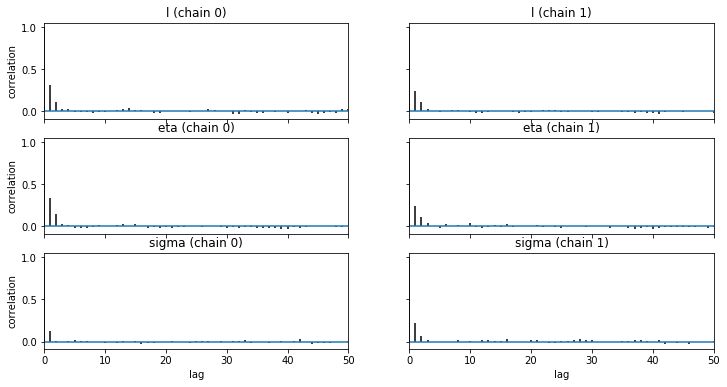

In [4]:
m, trace1 = IO('results/co2_regression_gp.pkl').read_pickle()
pm.autocorrplot(trace1, max_lag=50);

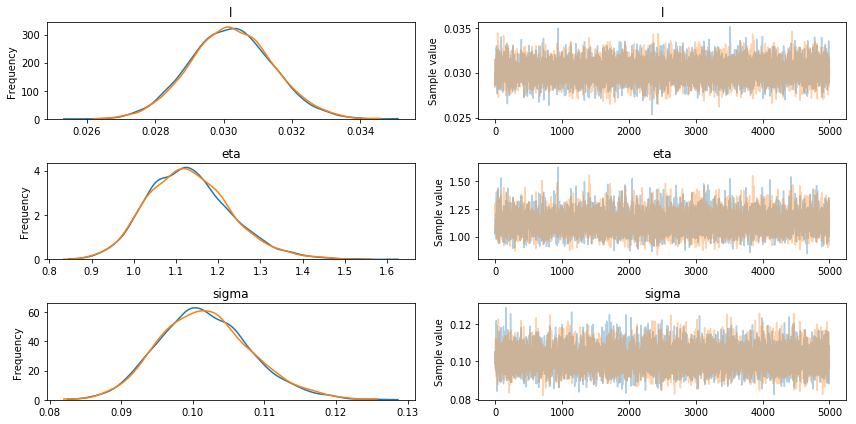

In [5]:
pm.traceplot(trace1);

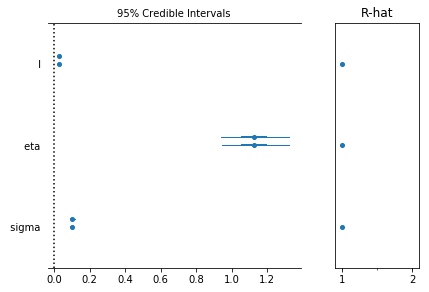

In [6]:
pm.forestplot(trace1);

In [ ]:
with m:
    y_gp = gp.conditional('y_pred', Xnew=X_test, pred_noise=True)
    gp_samples = pm.sample_ppc(trace1, vars=[y_gp], samples=10000)
ppc = gp_samples['y_pred']
y_gp_pred = ppc.mean(axis=0)
y_gp_std = ppc.std(axis=0)
IO('results/co2_regression_gp_results.pkl').to_pickle((y_gp_pred, y_gp_std))

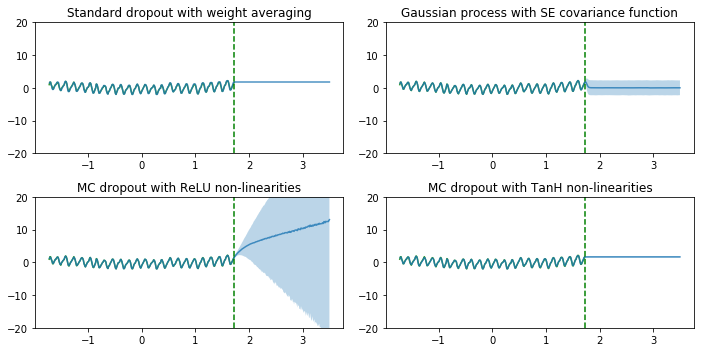

In [7]:
y_relu_pred, y_relu_mc, y_relu_mc_std = IO('results/co2_regression_MC_relu_results.pkl').read_pickle()
y_tanh_pred, y_tanh_mc, y_tanh_mc_std = IO('results/co2_regression_MC_tanh_results.pkl').read_pickle()
y_gp_pred, y_gp_std = IO('results/co2_regression_gp_results.pkl').read_pickle()

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_gp_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_gp_pred-2*y_gp_std, y_gp_pred+2*y_gp_std, alpha=0.3);
plt.title('Gaussian process with SE covariance function');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 4)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-20, 20]);

plt.tight_layout();

### 4.2. Dropout as Bayesian Approximation in Classification Task

In [1]:
import sys

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from keras.datasets import cifar10
from keras.datasets import mnist

from keras.utils import to_categorical
from keras import backend as K

import numpy as np
import pandas as pd
import time
from scipy.ndimage.interpolation import rotate

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns

import pickle

class IO:
    def __init__(self, file_name):
        self.file_name = file_name
        
    def to_pickle(self, obj):
        with open(self.file_name, 'wb') as output:
            pickle.dump(obj, output, protocol=pickle.HIGHEST_PROTOCOL)
    
    def read_pickle(self):
        with open(self.file_name, 'rb') as input_:
            obj = pickle.load(input_)
        return obj

Using TensorFlow backend.


In [2]:
# Load data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
X1 = np.array([rotate(X_test[9978], i, reshape=False) for i in range(60, 120, 5)])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
class LeNet:
    def __init__(self):
        model = Sequential()
        model.add(Conv2D(20, (5, 5), input_shape=(28, 28, 1), padding='same'))
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2), strides=2))
        model.add(Conv2D(50, (5, 5), padding='same'))
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2), strides=2))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(10))
        model.add(Activation('softmax'))
        self.model = model
        
    def fit(self, X_train, y_train, validation_data, lr=0.01, epochs=10, batch_size=64, verbose=0):
        self.model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=lr), metrics=['accuracy'])
        self.result = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, \
                                     validation_data=validation_data, verbose=verbose)
        return self

In [4]:
%%time

lenet1 = LeNet().fit(X_train, y_train, (X_test, y_test), epochs=100, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 14s 229us/step - loss: 0.5608 - acc: 0.8201 - val_loss: 0.4837 - val_acc: 0.9362
Epoch 2/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.2240 - acc: 0.9312 - val_loss: 0.3296 - val_acc: 0.9524
Epoch 3/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.1680 - acc: 0.9478 - val_loss: 0.2647 - val_acc: 0.9559
Epoch 4/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.1368 - acc: 0.9587 - val_loss: 0.2231 - val_acc: 0.9623
Epoch 5/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.1221 - acc: 0.9627 - val_loss: 0.2069 - val_acc: 0.9641
Epoch 6/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.1105 - acc: 0.9661 - val_loss: 0.1888 - val_acc: 0.9669
Epoch 7/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.1011 - acc: 0.9686 - val_l

Epoch 59/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0282 - acc: 0.9907 - val_loss: 0.0599 - val_acc: 0.9847
Epoch 60/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.0289 - acc: 0.9910 - val_loss: 0.0558 - val_acc: 0.9862
Epoch 61/100
60000/60000 [==============================] - 10s 162us/step - loss: 0.0282 - acc: 0.9908 - val_loss: 0.0529 - val_acc: 0.9871
Epoch 62/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0279 - acc: 0.9905 - val_loss: 0.0491 - val_acc: 0.9876
Epoch 63/100
60000/60000 [==============================] - 10s 162us/step - loss: 0.0268 - acc: 0.9915 - val_loss: 0.0575 - val_acc: 0.9847
Epoch 64/100
60000/60000 [==============================] - 10s 163us/step - loss: 0.0270 - acc: 0.9911 - val_loss: 0.0592 - val_acc: 0.9841
Epoch 65/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0273 - acc: 0.9912 - val_loss: 0.0485 - val_acc: 0.9877
Epoch 66/100


In [5]:
def predict(model, X, T=1000):
    standard_pred = model.predict_classes(X)
    f1 = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-2].output])
    f2 = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    y1 = np.array([f1([X, 1]) for _ in range(T)]).squeeze()
    y2 = np.array([f2([X, 1]) for _ in range(T)]).squeeze()
    return standard_pred, y1, y2

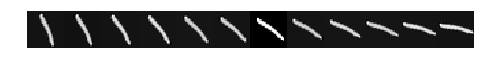

In [6]:
plt.figure(figsize=(8, 1))

gs = gridspec.GridSpec(1, 12)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1[i].squeeze(), cmap='gray');
    plt.axis('off');

In [7]:
%%time

y1_pred, y1_si, y1_so = predict(lenet1.model, X1)
print(y1_pred)

[1 1 1 1 1 5 5 5 7 7 7 7]
CPU times: user 4.47 s, sys: 672 ms, total: 5.14 s
Wall time: 3.7 s


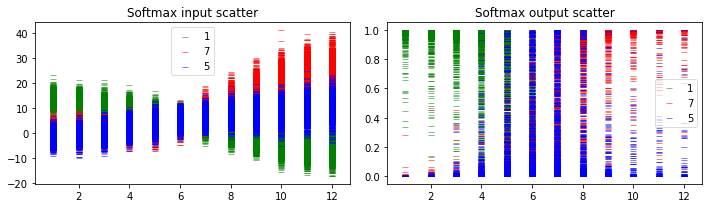

In [11]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.5, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.5, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 5].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.5, label='5');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.5, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.5, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 5].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.5, label='5');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();